In [1]:
import torch
import cv2
import numpy as np
from PIL import Image

from diffusers import StableDiffusionControlNetPipeline, ControlNetModel, DiffusionPipeline, LCMScheduler
from diffusers import StableDiffusionXLAdapterPipeline, T2IAdapter
from diffusers.utils import load_image, export_to_gif, make_image_grid

## LCM-LoRA
- https://huggingface.co/docs/diffusers/using-diffusers/inference_with_lcm_lora

In [4]:
pipe = DiffusionPipeline.from_pretrained(
    "stabilityai/stable-diffusion-xl-base-1.0",
    variant="fp16",
    torch_dtype=torch.float16
).to('cuda:1')

Fetching 19 files:   0%|          | 0/19 [00:00<?, ?it/s]

text_encoder_2/model.fp16.safetensors:   0%|          | 0.00/1.39G [00:00<?, ?B/s]

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

In [5]:
# scheduler
pipe.scheduler = LCMScheduler.from_config(pipe.scheduler.config) 

The config attributes {'skip_prk_steps': True} were passed to LCMScheduler, but are not expected and will be ignored. Please verify your scheduler_config.json configuration file.


In [6]:
# lora
pipe.load_lora_weights("latent-consistency/lcm-lora-sdxl", adapeter_name="lcm")
pipe.load_lora_weights("TheLastBen/Papercut_SDXL",  weight_name="papercut.safetensors", adapter_name="papercut")

pytorch_lora_weights.safetensors:   0%|          | 0.00/394M [00:00<?, ?B/s]

papercut.safetensors:   0%|          | 0.00/341M [00:00<?, ?B/s]

In [7]:
pipe.set_adapters(["lcm", "papercut"], adapter_weights=[1.0, 0.8])

In [34]:
generter = torch.manual_seed(0)

image = pipe(prompt="((cat))", num_inference_steps=6, guidance_rescale=7, generter=generter).images[0]
image

TypeError: image must be passed and be one of PIL image, numpy array, torch tensor, list of PIL images, list of numpy arrays or list of torch tensors, but is <class 'NoneType'>

## ControlNet / T2I adapter

In [2]:
image = load_image("https://hf.co/datasets/huggingface/documentation-images/resolve/main/diffusers/input_image_vermeer.png").resize((512,512))
image = np.array(image)

In [3]:
low_threashold = 100
high_threshold = 200

In [4]:
image = cv2.Canny(image, low_threashold, high_threshold)
image = image[:, :, None]
image = np.concatenate([image, image, image], axis=2)
canny_image = Image.fromarray(image)

### ControlNet

In [5]:
controlnet = ControlNetModel.from_pretrained("lllyasviel/sd-controlnet-canny", torch_dtype=torch.float16)

config.json:   0%|          | 0.00/920 [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/1.45G [00:00<?, ?B/s]

In [8]:
pipe = StableDiffusionControlNetPipeline.from_pretrained(
    "runwayml/stable-diffusion-v1-5",
    controlnet=controlnet,
    torch_dtype=torch.float16,
    safty_checker=None,
    variant="fp16"
).to('cuda')

Fetching 15 files:   0%|          | 0/15 [00:00<?, ?it/s]

(…)diffusion_pytorch_model.fp16.safetensors:   0%|          | 0.00/167M [00:00<?, ?B/s]

(…)diffusion_pytorch_model.fp16.safetensors:   0%|          | 0.00/1.72G [00:00<?, ?B/s]

safety_checker/model.fp16.safetensors:   0%|          | 0.00/608M [00:00<?, ?B/s]

text_encoder/model.fp16.safetensors:   0%|          | 0.00/246M [00:00<?, ?B/s]

Keyword arguments {'safty_checker': None} are not expected by StableDiffusionControlNetPipeline and will be ignored.


Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

In [10]:
# set scheduler
pipe.scheduler = LCMScheduler.from_config(pipe.scheduler.config)

# load LCM-LoRA
pipe.load_lora_weights("latent-consistency/lcm-lora-sdv1-5")

The config attributes {'skip_prk_steps': True} were passed to LCMScheduler, but are not expected and will be ignored. Please verify your scheduler_config.json configuration file.


pytorch_lora_weights.safetensors:   0%|          | 0.00/135M [00:00<?, ?B/s]

In [31]:
generator = torch.manual_seed(0)
image = pipe(
    "starry night",
    image=canny_image,
    num_inference_steps=4,
    guidance_scale=1.5,
    controlnet_conditioning_scale=0.8,
    cross_attention_kwargs={"scale": 1},
    generator=generator,
).images[0]

  0%|          | 0/4 [00:00<?, ?it/s]

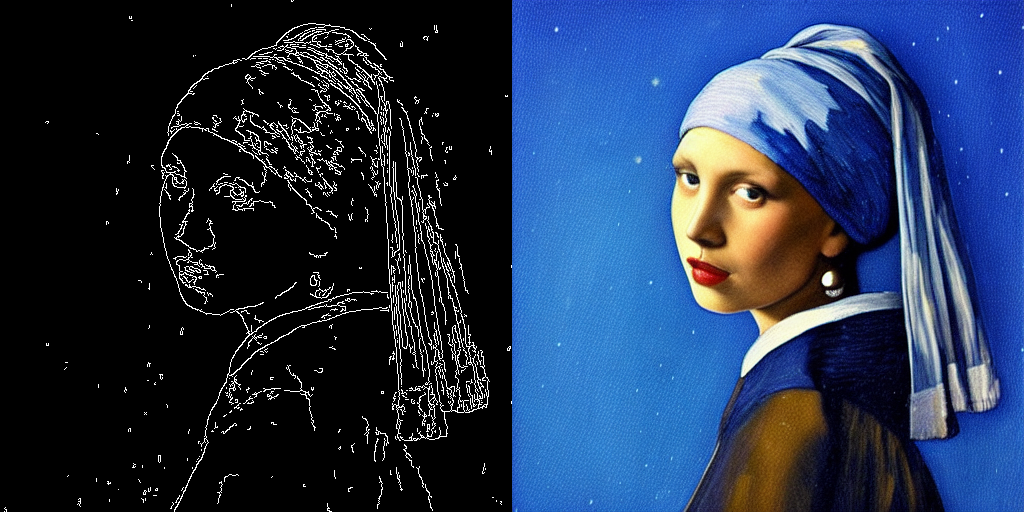

In [32]:
make_image_grid([canny_image, image], rows=1, cols=2)

### T2I adapter

In [5]:
# load adapter
t2iadapter = T2IAdapter.from_pretrained("TencentARC/t2i-adapter-canny-sdxl-1.0", torch_dtype=torch.float16, varient="fp16").to("cuda")

In [6]:
pipe = StableDiffusionXLAdapterPipeline.from_pretrained(
    "stabilityai/stable-diffusion-xl-base-1.0", 
    adapter=t2iadapter,
    torch_dtype=torch.float16,
    variant="fp16", 
).to("cuda")

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

In [7]:
# scheduler
pipe.scheduler = LCMScheduler.from_config(pipe.scheduler.config)

# load LCM-lora
pipe.load_lora_weights("latent-consistency/lcm-lora-sdxl")

The config attributes {'skip_prk_steps': True} were passed to LCMScheduler, but are not expected and will be ignored. Please verify your scheduler_config.json configuration file.


In [8]:
generator = torch.manual_seed(0)
image = pipe(
    prompt="starry night",
    negative_prompt="ugly, distorb",
    image=canny_image,
    num_inference_steps=4,
    guidance_scale=1.5, 
    adapter_conditioning_scale=0.8, 
    adapter_conditioning_factor=1,
    generator=generator,
).images[0]

  0%|          | 0/4 [00:00<?, ?it/s]

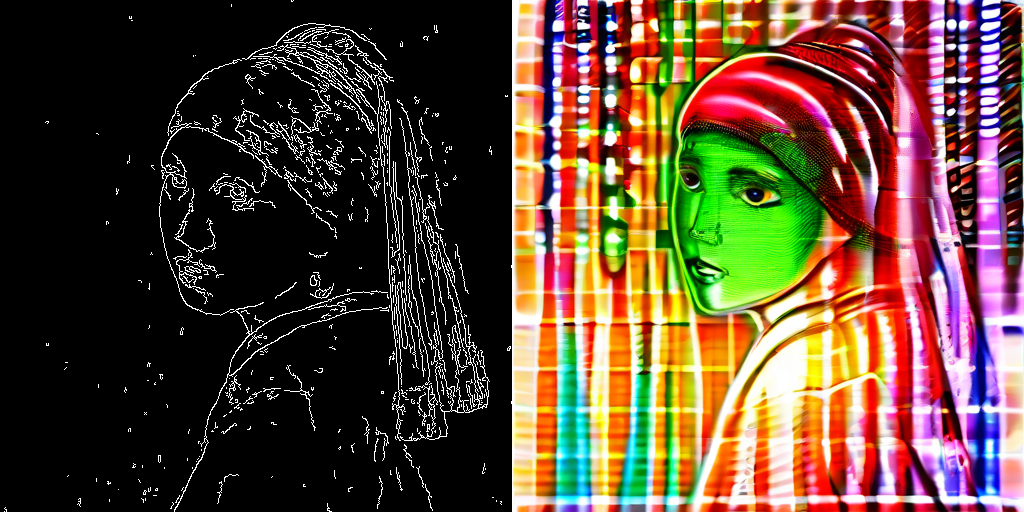

In [9]:
make_image_grid([canny_image, image], rows=1, cols=2)